In [86]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [4]:
%matplotlib inline
#%pylab inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import athena4_read as ath

# 1.basic procedure for the null point identification

considering the B-components are on corners.
* (1) **reduction**: loop over all corner $B_x$,$B_y$, and $B_z$, if either of them are always positive/negative: remove them from null candidate list.
* (2) **selection**: For each faces, calculate the intersection curves for $B_x=B_y=0$, $B_y=B_z=0$, and also $B_x=B_z=0$. Given their bilinear properties on the cell faces, it reduces to solve 

   $(a_1c_2-a_2c_1)+[(a_1d_2-a_2d_1)+(b_1c_2-b_2c_1)]x_i + (b_1d_2-b_2d_1)x_i^2=0\,,$
   
   $x_j = -(a_1+b_1x_i)/(c_1+d_1x_i)\,,$ where subscript 1 and 2 $\in \{x,y,z\}$ depends on the cell face(e.g., 1='y',2='z' if choose face $x=0$)
*  if the solution to above quadratic formula is complex (no intersection), $< 0$ or $> 1$ (intersecting outside the cell): does not represent an intersection point. Otherwise, we found an intersection point!
*  Count intersection point for $B_i=0$ and $B_j=0$ for all six faces. A null point has to satisfy the following criteria <font color='orange'>(is this sufficient?)</font>:
*    (I) for each pair of intersection curves (e.g., $B_x=B_y=0$), the intersection points are paired (even number) 
*    (II) the third component (e.g.,$B_z$ in case we considering $B_x=B_y=0$) should have opposite signs in half of those intersection points. Could be all zeros I guess. 

         
  

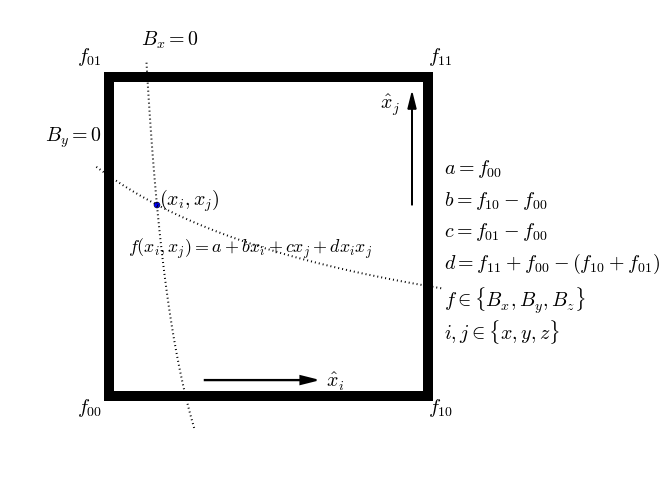

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 8)
plt.axis('off')
#plt.arrow(0, 0, 0.5, 0.5, head_width=0.05, head_length=0.1, fc='k', ec='k');
plt.plot([0,1],[0,0],c='k',lw=10)
plt.plot([0,1],[1,1],c='k',lw=10)
plt.plot([0,0],[0,1],c='k',lw=10)
plt.plot([1,1],[0,1],c='k',lw=10)
plt.text(-0.1,-0.05,r'$f_{00}$',size=20)
plt.text(1., -0.05, r'$f_{10}$',size=20)
plt.text(1.,1.05,   r'$f_{11}$',size=20)
plt.text(-0.1,1.05,r'$f_{01}$',size=20)
plt.text(0.155,0.6,  r'$(x_i,x_j)$',size=20)
plt.plot(0.15,0.6,marker='o')
ys = np.linspace(-0.1,1.05,40)
xs = 0.24/(1.0+ys)
plt.plot(xs,ys,'k:')

xs = np.linspace(-0.04,1.05,40)
ys = 0.69/(1.0+xs)
plt.plot(xs,ys,'k:')
plt.text(0.1,1.1,r'$B_x=0$',size=20)
plt.text(-0.2,0.8,r'$B_y=0$',size=20)

plt.text(0.06,0.45,r'$f(x_i,x_j) = a + bx_i + cx_j + dx_i x_j$',size=18)
plt.text(1.05,0.4,r'$d = f_{11}+f_{00}-(f_{10}+f_{01})$',size=20)
plt.text(1.05,0.7,r'$a = f_{00}$',size=20)
plt.text(1.05,0.6,r'$b = f_{10}-f_{00}$',size=20)
plt.text(1.05,0.5,r'$c = f_{01}-f_{00}$',size=20)
plt.text(1.05,0.28,r'$f \in \{B_x,B_y,B_z\}$',size=20)
plt.text(1.05,0.18,r'$i,j \in \{x,y,z\}$',size=20)
plt.arrow(0.3,0.05,0.3,0,head_width=0.025,head_length=0.05,fc='k',ec='k',lw=2)
plt.arrow(0.95,0.6,0.,0.3,head_width=0.025,head_length=0.05,fc='k',ec='k',lw=1.5)
plt.text(0.68,0.03,r'$\hat{x}_i$',size=20)
plt.text(0.85,0.9,r'$\hat{x}_j$',size=20)

plt.axes().set_aspect('equal')


# 2. reduction

In [5]:
t,x,y,z,data=ath.vtk('Unstra.0080.vtk')
bx = data['cell_centered_B'][...,0]
by = data['cell_centered_B'][...,1]
bz = data['cell_centered_B'][...,2]

time =  2481.862
face_dimensions =  [65, 257, 257]
-5.000000e-01 -2.000000e+00 -2.000000e+00
box_origin =  [-0.5, -2.0, -2.0]
1.562500e-02 1.562500e-02 1.562500e-02
grid_spacing =  [0.015625, 0.015625, 0.015625]
cell_dimensions =  [256 256  64]  num_cells =  4194304
SCALARS
start loading scalars !! 
loading array_name =  density
is,ie =  297 16777513
data[density].shape=  (256, 256, 64)
VECTORS
VECTORS
start loading vectors !! 
loading array_name =  momentum
VECTORS
VECTORS
start loading vectors !! 
loading array_name =  cell_centered_B


### 2.1. reduction with nested for-loop in series: too slow

In [28]:
nx = bx.shape[2]
ny = bx.shape[1]
nz = bx.shape[0]

import time

def positive_negative(inputlist):
  if ((all(item>0 for item in list(inputlist))) or (all(item<0 for item in list(inputlist)))):
    return True
  else:
    return False # elements with diff sign or all zeros;
         

#print nx,ny,nz
candidate = []
tstart = time.time()
for k in range(nz-1):
  for j in range(ny-1):
    for i in range(nx-1):
      corner=bx[k:k+2,j:j+2,i:i+2]
      is_bx = positive_negative(np.ravel(corner))
      corner=by[k:k+2,j:j+2,i:i+2]
      is_by = positive_negative(np.ravel(corner))
      corner=bz[k:k+2,j:j+2,i:i+2]
      is_bz = positive_negative(np.ravel(corner))
      if ((is_bx or is_by or is_bz) == False):
        candidate.append([k,j,i])

tend = time.time()
print len(candidate)
print candidate[:5]
print 'time cost = ',tend-tstart,' second'
        

77860
[[0, 1, 11], [0, 2, 11], [0, 3, 11], [0, 19, 11], [0, 20, 11]]
time cost =  210.98925209  second


### 2.2. reduction using parallelized for-loop
* using 8 processes, takes 38 sec compared to the above 210 sec..
* part of the 38 sec is used to clean-up the None in the list (Any way to not including those None in the first place??)
* change the candidate_list to save tuples in the list instead of list in a list

In [21]:
import time
import multiprocessing as mp
from itertools import product


tstart = time.time()  
nx = bx.shape[2]
ny = bx.shape[1]
nz = bx.shape[0]  # shrink 4 times for test/debug purpose.
#contruct list of argument for parallelization
klist,jlist,ilist = zip(*product(range(nz-1),range(ny-1),range(nx-1)))
#print klist[256*64/4:256*64/4+10]


def positive_negative(inputlist):
  if ((all(item>0 for item in list(inputlist))) or (all(item<0 for item in list(inputlist)))):
    return True  # elements with same sign (+ or -)
  else:
    return False # elements with diff sign or all zeros;
 

def f(location):
  #candidate_pl = []
  k = location[0];j=location[1];i=location[2]
  corner=bx[k:k+2,j:j+2,i:i+2]
  is_bx = positive_negative(np.ravel(corner))
  corner=by[k:k+2,j:j+2,i:i+2]
  is_by = positive_negative(np.ravel(corner))
  corner=bz[k:k+2,j:j+2,i:i+2]
  is_bz = positive_negative(np.ravel(corner))
  if ((is_bx or is_by or is_bz) == False):
    #candidate_pl.append((k,j,i)) 
    #print '[k,j,i]=',k,j,i
    #print 'length of candiate=',len(candidate_pl)
    return (k,j,i) #candidate_pl
  else:
    return None

result_list=[]
candidate_list=[]
#create a pool and map the target function with multi-arguments
p = mp.Pool(processes=8)
result_list = p.map(f,zip(klist,jlist,ilist))
candidate_list = [item for item in result_list if item is not None]

tend = time.time()

del result_list

print len(candidate_list)
print
print candidate_list[:5]
print
print 'time cost = ',tend-tstart,' second'

77860

[(0, 1, 11), (0, 2, 11), (0, 3, 11), (0, 19, 11), (0, 20, 11)]

time cost =  31.4930899143  second


In [25]:
p.terminate()
p.close()

### check if the above algorithm is correct. 

In [26]:
k = 0; j=1; i=11
corner=bx[k:k+2,j:j+2,i:i+2]
print positive_negative(np.ravel(corner))
corner=by[k:k+2,j:j+2,i:i+2]
print positive_negative(np.ravel(corner))
corner=bz[k:k+2,j:j+2,i:i+2]
print positive_negative(np.ravel(corner))


False
False
False


## dump/restore with pickle

In [5]:
import pickle

## dump the candidate_list
pickle.dump(candidate_list, open( "candidate.p", "wb" ) )


# for the following development, we could simply load the 
# list below and carry on the calculation
candidate_list = pickle.load( open( "candidate.p", "rb" ) )
print len(candidate_list)
print
print candidate_list[:5]


77860

[(0, 1, 11), (0, 2, 11), (0, 3, 11), (0, 19, 11), (0, 20, 11)]


# 3. selection
## 3.1. finding intersection points by bilinear interpolation over cell faces

### $B_x=B_y=0$ on one face ($x=0$): $f(x,y) = B_x$, or $B_y$
$B_x=0 \Rightarrow B_x(0,0)+[B_x(1,0)-B_x(0,0)]y+[B_x(0,1)-B_x(0,0)]z + [B_x(0,0)+B_x(1,1)-B_x(1,0)-B_x(0,1)] yz = 0$

$B_y=0 \Rightarrow B_y(0,0)+[B_y(1,0)-B_y(0,0)]y+[B_y(0,1)-B_y(0,0)]z + [B_y(0,0)+B_y(1,1)-B_y(1,0)-B_y(0,1)] yz = 0$

In [3]:
# function which takes the cell location and solve for intersection points on six surfaces
def bilinear(x,y,f00,f01,f10,f11):
   a = f00; b = f10-f00; c = f01-f00; d = f00+f11-f10-f01
   fxy = a + b*x + c*y + d*x*y
   return fxy

# test if a list has equal number of positive
# and negative values; zeros belong to both.
def issym(b3):
  npos = 0; nneg = 0
  for item in b3:
    if (item >= 0): 
      npos +=1
    if (item <= 0):
      nneg +=1
  if (npos==nneg):
    return True
  else:
    return False

###############################################
# intersection curves Bx=By=0
###############################################
def intersect_bxby(location):
  npts = 0 # # of end points
  b3 = [] # third component values
  sk = location[0];sj=location[1];si=location[2]
  f = bx; g = by; h = bz
    
  for nface in range(6):
    if (nface == 0):  # x = 0 face (y,z) 
      f00,f01,f10,f11 = f[sk,sj,si],f[sk+1,sj,si],f[sk,sj+1,si],f[sk+1,sj+1,si]
      g00,g01,g10,g11 = g[sk,sj,si],g[sk+1,sj,si],g[sk,sj+1,si],g[sk+1,sj+1,si]
      h00,h01,h10,h11 = h[sk,sj,si],h[sk+1,sj,si],h[sk,sj+1,si],h[sk+1,sj+1,si]
    if (nface == 1): # x=1 face 
      f00,f01,f10,f11 = f[sk,sj,si+1],f[sk+1,sj,si+1],f[sk,sj+1,si+1],f[sk+1,sj+1,si+1]
      g00,g01,g10,g11 = g[sk,sj,si+1],g[sk+1,sj,si+1],g[sk,sj+1,si+1],g[sk+1,sj+1,si+1]
      h00,h01,h10,h11 = h[sk,sj,si+1],h[sk+1,sj,si+1],h[sk,sj+1,si+1],h[sk+1,sj+1,si+1]
    if (nface == 2):  # y = 0 face (x,z) 
      f00,f01,f10,f11 = f[sk,sj,si],f[sk+1,sj,si],f[sk,sj,si+1],f[sk+1,sj,si+1]
      g00,g01,g10,g11 = g[sk,sj,si],g[sk+1,sj,si],g[sk,sj,si+1],g[sk+1,sj,si+1]
      h00,h01,h10,h11 = h[sk,sj,si],h[sk+1,sj,si],h[sk,sj,si+1],h[sk+1,sj,si+1]
    if (nface == 3): # y =1 face
      f00,f01,f10,f11 = f[sk,sj+1,si],f[sk+1,sj+1,si],f[sk,sj+1,si+1],f[sk+1,sj+1,si+1]
      g00,g01,g10,g11 = g[sk,sj+1,si],g[sk+1,sj+1,si],g[sk,sj+1,si+1],g[sk+1,sj+1,si+1]
      h00,h01,h10,h11 = h[sk,sj+1,si],h[sk+1,sj+1,si],h[sk,sj+1,si+1],h[sk+1,sj+1,si+1]
    if (nface == 4): # z = 0 face (x,y)
      f00,f01,f10,f11 = f[sk,sj,si],f[sk,sj+1,si],f[sk,sj,si+1],f[sk,sj+1,si+1]
      g00,g01,g10,g11 = g[sk,sj,si],g[sk,sj+1,si],g[sk,sj,si+1],g[sk,sj+1,si+1]
      h00,h01,h10,h11 = h[sk,sj,si],h[sk,sj+1,si],h[sk,sj,si+1],h[sk,sj+1,si+1]
    if (nface == 5): # z=1 face
      f00,f01,f10,f11 = f[sk+1,sj,si],f[sk+1,sj+1,si],f[sk+1,sj,si+1],f[sk+1,sj+1,si+1]
      g00,g01,g10,g11 = g[sk+1,sj,si],g[sk+1,sj+1,si],g[sk+1,sj,si+1],g[sk+1,sj+1,si+1] 
      h00,h01,h10,h11 = h[sk+1,sj,si],h[sk+1,sj+1,si],h[sk+1,sj,si+1],h[sk+1,sj+1,si+1]
        
    a1,b1,c1,d1 = f00,f10-f00,f01-f00,f00+f11-f10-f01
    a2,b2,c2,d2 = g00,g10-g00,g01-g00,g00+g11-g10-g01
    coeff = [(b1*d2-b2*d1), (a1*d2-a2*d1+b1*c2-b2*c1), (a1*c2-a2*c1)]
    sol1 = np.roots(coeff)
    sol2 = -(a2+b2*sol1)/(c2+d2*sol1)
    #  determine if intersection points
    for s,t in zip(sol1,sol2):
       if ((not isinstance(s,complex)) and (not isinstance(t,complex))): 
         if (s>=0 and s<=1 and t>=0 and t<=1):
           npts += 1
           # if yes, calculate the third components on those points
           b3.append(bilinear(s,t,h00,h01,h10,h11))

  #  determine if null pt: (1) intersection points in pair (2) third component flip signs
  #  if yes then return True; else return False
  if (npts>0 and npts%2==0): 
    return issym(b3) 
  else:
    return False

###############################################
# intersection curves By=Bz=0
###############################################
def intersect_bybz(location):
  npts = 0 # # of end points
  b3 = [] # third component values
  sk = location[0];sj=location[1];si=location[2]
  f = by; g = bz; h = bx
    
  for nface in range(6):
    if (nface == 0):  # x = 0 face (y,z) 
      f00,f01,f10,f11 = f[sk,sj,si],f[sk+1,sj,si],f[sk,sj+1,si],f[sk+1,sj+1,si]
      g00,g01,g10,g11 = g[sk,sj,si],g[sk+1,sj,si],g[sk,sj+1,si],g[sk+1,sj+1,si]
      h00,h01,h10,h11 = h[sk,sj,si],h[sk+1,sj,si],h[sk,sj+1,si],h[sk+1,sj+1,si]
    if (nface == 1): # x=1 face 
      f00,f01,f10,f11 = f[sk,sj,si+1],f[sk+1,sj,si+1],f[sk,sj+1,si+1],f[sk+1,sj+1,si+1]
      g00,g01,g10,g11 = g[sk,sj,si+1],g[sk+1,sj,si+1],g[sk,sj+1,si+1],g[sk+1,sj+1,si+1]
      h00,h01,h10,h11 = h[sk,sj,si+1],h[sk+1,sj,si+1],h[sk,sj+1,si+1],h[sk+1,sj+1,si+1]
    if (nface == 2):  # y = 0 face (x,z) 
      f00,f01,f10,f11 = f[sk,sj,si],f[sk+1,sj,si],f[sk,sj,si+1],f[sk+1,sj,si+1]
      g00,g01,g10,g11 = g[sk,sj,si],g[sk+1,sj,si],g[sk,sj,si+1],g[sk+1,sj,si+1]
      h00,h01,h10,h11 = h[sk,sj,si],h[sk+1,sj,si],h[sk,sj,si+1],h[sk+1,sj,si+1]
    if (nface == 3): # y =1 face
      f00,f01,f10,f11 = f[sk,sj+1,si],f[sk+1,sj+1,si],f[sk,sj+1,si+1],f[sk+1,sj+1,si+1]
      g00,g01,g10,g11 = g[sk,sj+1,si],g[sk+1,sj+1,si],g[sk,sj+1,si+1],g[sk+1,sj+1,si+1]
      h00,h01,h10,h11 = h[sk,sj+1,si],h[sk+1,sj+1,si],h[sk,sj+1,si+1],h[sk+1,sj+1,si+1]
    if (nface == 4): # z = 0 face (x,y)
      f00,f01,f10,f11 = f[sk,sj,si],f[sk,sj+1,si],f[sk,sj,si+1],f[sk,sj+1,si+1]
      g00,g01,g10,g11 = g[sk,sj,si],g[sk,sj+1,si],g[sk,sj,si+1],g[sk,sj+1,si+1]
      h00,h01,h10,h11 = h[sk,sj,si],h[sk,sj+1,si],h[sk,sj,si+1],h[sk,sj+1,si+1]
    if (nface == 5): # z=1 face
      f00,f01,f10,f11 = f[sk+1,sj,si],f[sk+1,sj+1,si],f[sk+1,sj,si+1],f[sk+1,sj+1,si+1]
      g00,g01,g10,g11 = g[sk+1,sj,si],g[sk+1,sj+1,si],g[sk+1,sj,si+1],g[sk+1,sj+1,si+1] 
      h00,h01,h10,h11 = h[sk+1,sj,si],h[sk+1,sj+1,si],h[sk+1,sj,si+1],h[sk+1,sj+1,si+1]
        
    a1,b1,c1,d1 = f00,f10-f00,f01-f00,f00+f11-f10-f01
    a2,b2,c2,d2 = g00,g10-g00,g01-g00,g00+g11-g10-g01
    coeff = [(b1*d2-b2*d1), (a1*d2-a2*d1+b1*c2-b2*c1), (a1*c2-a2*c1)]
    sol1 = np.roots(coeff)
    sol2 = -(a2+b2*sol1)/(c2+d2*sol1)
    #  determine if intersection points
    for s,t in zip(sol1,sol2):
       if ((not isinstance(s,complex)) and (not isinstance(t,complex))): 
         if (s>=0 and s<=1 and t>=0 and t<=1):
           npts += 1
           # if yes, calculate the third components on those points
           b3.append(bilinear(s,t,h00,h01,h10,h11))

  #  determine if null pt: (1) intersection points in pair (2) third component flip signs
  #  if yes then return True; else return False
  if (npts>0 and npts%2==0): 
    return issym(b3) 
  else:
    return False

###############################################
# intersection curves Bx=Bz=0
###############################################
def intersect_bxbz(location):
  npts = 0 # # of end points
  b3 = [] # third component values
  sk = location[0];sj=location[1];si=location[2]
  f = bx; g = bz; h = by
    
  for nface in range(6):
    if (nface == 0):  # x = 0 face (y,z) 
      f00,f01,f10,f11 = f[sk,sj,si],f[sk+1,sj,si],f[sk,sj+1,si],f[sk+1,sj+1,si]
      g00,g01,g10,g11 = g[sk,sj,si],g[sk+1,sj,si],g[sk,sj+1,si],g[sk+1,sj+1,si]
      h00,h01,h10,h11 = h[sk,sj,si],h[sk+1,sj,si],h[sk,sj+1,si],h[sk+1,sj+1,si]
    if (nface == 1): # x=1 face 
      f00,f01,f10,f11 = f[sk,sj,si+1],f[sk+1,sj,si+1],f[sk,sj+1,si+1],f[sk+1,sj+1,si+1]
      g00,g01,g10,g11 = g[sk,sj,si+1],g[sk+1,sj,si+1],g[sk,sj+1,si+1],g[sk+1,sj+1,si+1]
      h00,h01,h10,h11 = h[sk,sj,si+1],h[sk+1,sj,si+1],h[sk,sj+1,si+1],h[sk+1,sj+1,si+1]
    if (nface == 2):  # y = 0 face (x,z) 
      f00,f01,f10,f11 = f[sk,sj,si],f[sk+1,sj,si],f[sk,sj,si+1],f[sk+1,sj,si+1]
      g00,g01,g10,g11 = g[sk,sj,si],g[sk+1,sj,si],g[sk,sj,si+1],g[sk+1,sj,si+1]
      h00,h01,h10,h11 = h[sk,sj,si],h[sk+1,sj,si],h[sk,sj,si+1],h[sk+1,sj,si+1]
    if (nface == 3): # y =1 face
      f00,f01,f10,f11 = f[sk,sj+1,si],f[sk+1,sj+1,si],f[sk,sj+1,si+1],f[sk+1,sj+1,si+1]
      g00,g01,g10,g11 = g[sk,sj+1,si],g[sk+1,sj+1,si],g[sk,sj+1,si+1],g[sk+1,sj+1,si+1]
      h00,h01,h10,h11 = h[sk,sj+1,si],h[sk+1,sj+1,si],h[sk,sj+1,si+1],h[sk+1,sj+1,si+1]
    if (nface == 4): # z = 0 face (x,y)
      f00,f01,f10,f11 = f[sk,sj,si],f[sk,sj+1,si],f[sk,sj,si+1],f[sk,sj+1,si+1]
      g00,g01,g10,g11 = g[sk,sj,si],g[sk,sj+1,si],g[sk,sj,si+1],g[sk,sj+1,si+1]
      h00,h01,h10,h11 = h[sk,sj,si],h[sk,sj+1,si],h[sk,sj,si+1],h[sk,sj+1,si+1]
    if (nface == 5): # z=1 face
      f00,f01,f10,f11 = f[sk+1,sj,si],f[sk+1,sj+1,si],f[sk+1,sj,si+1],f[sk+1,sj+1,si+1]
      g00,g01,g10,g11 = g[sk+1,sj,si],g[sk+1,sj+1,si],g[sk+1,sj,si+1],g[sk+1,sj+1,si+1] 
      h00,h01,h10,h11 = h[sk+1,sj,si],h[sk+1,sj+1,si],h[sk+1,sj,si+1],h[sk+1,sj+1,si+1]
        
    a1,b1,c1,d1 = f00,f10-f00,f01-f00,f00+f11-f10-f01
    a2,b2,c2,d2 = g00,g10-g00,g01-g00,g00+g11-g10-g01
    coeff = [(b1*d2-b2*d1), (a1*d2-a2*d1+b1*c2-b2*c1), (a1*c2-a2*c1)]
    sol1 = np.roots(coeff)
    sol2 = -(a2+b2*sol1)/(c2+d2*sol1)
    #  determine if intersection points
    for s,t in zip(sol1,sol2):
       if ((not isinstance(s,complex)) and (not isinstance(t,complex))): 
         if (s>=0 and s<=1 and t>=0 and t<=1):
           npts += 1
           # if yes, calculate the third components on those points
           b3.append(bilinear(s,t,h00,h01,h10,h11))

  #  determine if null pt: (1) intersection points in pair (2) third component flip signs
  #  if yes then return True; else return False
  if (npts>0 and npts%2==0): 
    return issym(b3) 
  else:
    return False

## 3.2. identify 3D null point by number of intersection points and the values of the third component

In [5]:
import time
import multiprocessing as mp
from itertools import product


tstart = time.time()  

#create a pool and map the target function with multi-arguments
p = mp.Pool(processes=8)

# first pass: finding intersection of Bx=By=0
mask_list = p.map(intersect_bxby, candidate_list)
cell = [candidate_list[i] for i in range(len(candidate_list)) if mask_list[i]]
               

tend = time.time()
print 'time cost for the 1st pass = ',tend-tstart,' seconds'
#print type(cell)
#print cell[:5]
#print len(cell)

tstart = time.time() 
# second pass: finding intersection of By=Bz=0
for cell_one in cell:
  if (not intersect_bybz(cell_one)):
    cell.remove(cell_one)
tend = time.time()
print 'time cost for the 2nd pass = ',tend-tstart,' seconds'
#print type(cell)
#print cell[:5]
#print len(cell)


# third pass: finding intersection of Bx=Bz=0
for cell_one in cell:
  if (not intersect_bxbz(cell_one)):
    cell.remove(cell_one) 
tend = time.time()
print 'time cost for the 3rd pass = ',tend-tstart,' seconds'
#print type(cell)
#print cell[:5]
#print len(cell)
print
print 'find ',len(cell),' magnetic null points'

time cost for the 1st pass =  10.4547650814  seconds
time cost for the 2nd pass =  0.463422060013  seconds
time cost for the 3rd pass =  0.934571027756  seconds

find  536  magnetic null points


## save the location of null points

In [6]:
import pickle

# dump the magnetic null
pickle.dump(cell, open( "null.p", "wb" ) )


# for the following development, we could simply load the 
# list below and carry on the calculation
cell = pickle.load( open( "null.p", "rb" ) )
print len(cell)
print
print cell[:5]


536

[(1, 186, 23), (2, 56, 11), (6, 167, 19), (8, 154, 26), (10, 79, 2)]


## 3.3. Visualize the spatial distribution of the null points

<IPython.core.display.Javascript object>


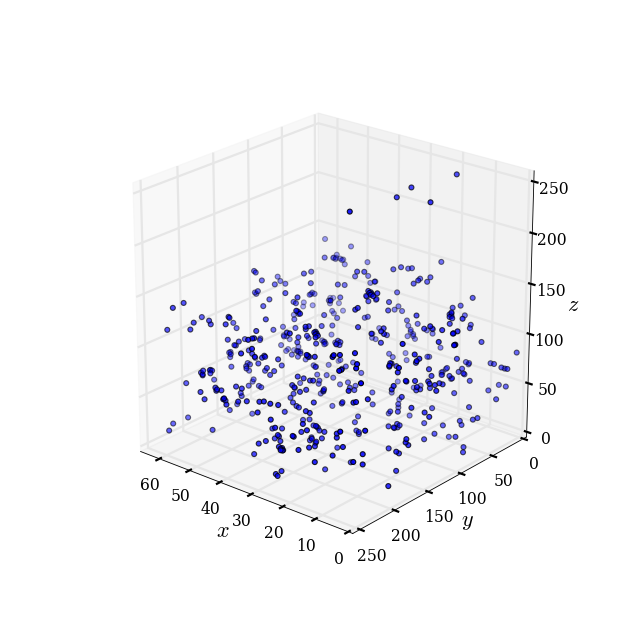

In [7]:
xloc = np.array(cell)[:,2]
yloc = np.array(cell)[:,1]
zloc = np.array(cell)[:,0]

#
# try to visualize the spatial distribution of null points
#
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
%matplotlib notebook

# create the scatter plot
matplotlib.rcParams['figure.figsize'] = (8, 8)
fig = plt.figure()
fraction=0.025;pad=0.08
ax = fig.gca(projection='3d')

#ax = Axes3D(fig)
ax.scatter(xloc, yloc, zloc,marker='o')



ax.set_xlim3d(0, 65)
ax.set_ylim3d(0, 255)
ax.set_zlim3d(0, 255)

ax.set_xlabel(r'$x$',size=20)
ax.set_ylabel(r'$y$',size=20)
ax.set_zlabel(r'$z$',size=20)
ax.view_init(elev=22, azim=130)

    

## 3.4.  find null points on current sheets

In [8]:
import cPickle as pickle
jlist_sorted = pickle.load( open( "jlist.p", "rb" ) )
print len(jlist_sorted),' current sheets'


null = pickle.load( open( "null.p", "rb" ) )
print len(null), ' magnetic null points'
print
print null[:5]

831  current sheets
536  magnetic null points

[(1, 186, 23), (2, 56, 11), (6, 167, 19), (8, 154, 26), (10, 79, 2)]


## the number density of null points on current sheet is twice higher than uniform distributed over the box

In [9]:
# search for the current sheet given a null point? 
identity = {}
jvolume = 0.0; numnull = float(len(null))
for i in range(0,len(jlist_sorted)):
  jvolume +=len(jlist_sorted[i]) # obtain total volume
  for location in null:
    if location in jlist_sorted[i]:
      null.remove(location)
      identity[location] = i # store null pt location:index of current sheet key:value pair
print len(identity)
print identity
print 
# calc the number density of null points on current sheet or in the whole box
totvolume = float(nx*ny*nz)
print "current sheet volume / whole box volume = ", jvolume/totvolume
print "number density of null points in whole volume = ", numnull/totvolume
print "number density of null points in current sheet = ", float(len(identity))/jvolume


16
{(39, 187, 23): 7, (52, 211, 14): 22, (36, 238, 25): 16, (72, 235, 45): 15, (92, 29, 30): 88, (56, 211, 14): 22, (45, 231, 11): 7, (75, 243, 35): 153, (131, 243, 0): 9, (74, 216, 53): 15, (123, 93, 56): 4, (36, 234, 26): 16, (90, 162, 54): 187, (51, 221, 4): 7, (36, 236, 26): 16, (66, 140, 6): 29}

current sheet volume / whole box volume =  0.0157234668732
number density of null points in whole volume =  0.000127792358398
number density of null points in current sheet =  0.000242611715113


## show null points embedded in current sheet

[[ 39 187  23]
 [ 45 231  11]
 [ 51 221   4]]

[23 11  4] [187 231 221] [39 45 51]
(2066, 3)


<IPython.core.display.Javascript object>


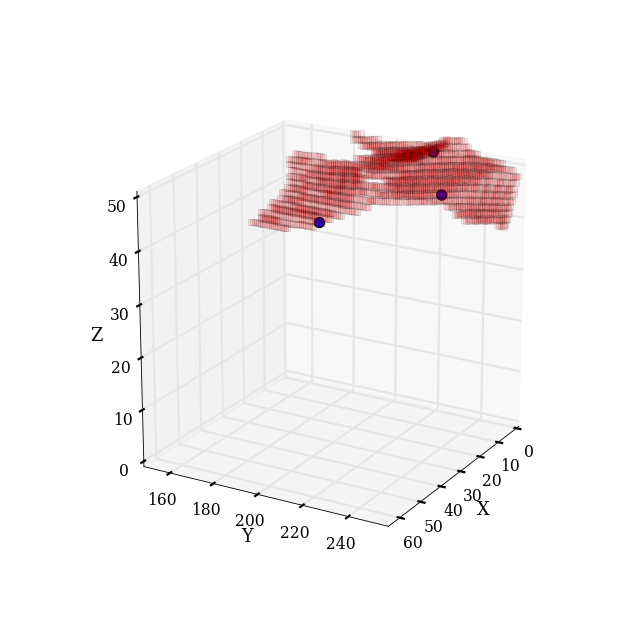

In [10]:
jsheet = jlist_sorted[7]
points = np.array([k for k in identity if identity[k]==7])
xpt = points[:,2]; ypt = points[:,1]; zpt = points[:,0]
print points
print
print xpt,ypt,zpt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
%matplotlib notebook

# prepare grid points with sheet found above
locs = np.array(jsheet.keys())  
print locs.shape

# create the scatter plot
matplotlib.rcParams['figure.figsize'] = (8, 8)
fig = plt.figure()
fraction=0.025;pad=-0.1
ax = fig.gca(projection='3d')

ax.scatter(locs[:,2], locs[:,1], locs[:,0],marker='s',s=30,c='r',alpha=0.1)

ax.scatter(xpt,ypt,zpt,marker='o',s=85,c='b',alpha=1)

ax.set_xlim3d(0, 64)
ax.set_ylim3d(150, 255)
ax.set_zlim3d(0, 50)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=20, azim=30)    

## 3.4.  Test the algorithm
* set up a null point $\mathbf{B} = (x,py,-(p+1)z)$, $p=1$
* construct the above field structure on 3d grids $8\times8\times8$
<img src='download/spine_fan_cartoon.jpg' width=300>

[-0.5        -0.48989899 -0.47979798 -0.46969697 -0.45959596 -0.44949495
 -0.43939394 -0.42929293 -0.41919192 -0.40909091 -0.3989899  -0.38888889
 -0.37878788 -0.36868687 -0.35858586 -0.34848485 -0.33838384 -0.32828283
 -0.31818182 -0.30808081 -0.2979798  -0.28787879 -0.27777778 -0.26767677
 -0.25757576 -0.24747475 -0.23737374 -0.22727273 -0.21717172 -0.20707071
 -0.1969697  -0.18686869 -0.17676768 -0.16666667 -0.15656566 -0.14646465
 -0.13636364 -0.12626263 -0.11616162 -0.10606061 -0.0959596  -0.08585859
 -0.07575758 -0.06565657 -0.05555556 -0.04545455 -0.03535354 -0.02525253
 -0.01515152 -0.00505051  0.00505051  0.01515152  0.02525253  0.03535354
  0.04545455  0.05555556  0.06565657  0.07575758  0.08585859  0.0959596
  0.10606061  0.11616162  0.12626263  0.13636364  0.14646465  0.15656566
  0.16666667  0.17676768  0.18686869  0.1969697   0.20707071  0.21717172
  0.22727273  0.23737374  0.24747475  0.25757576  0.26767677  0.27777778
  0.28787879  0.2979798   0.30808081  0.31818182  0.

<IPython.core.display.Javascript object>


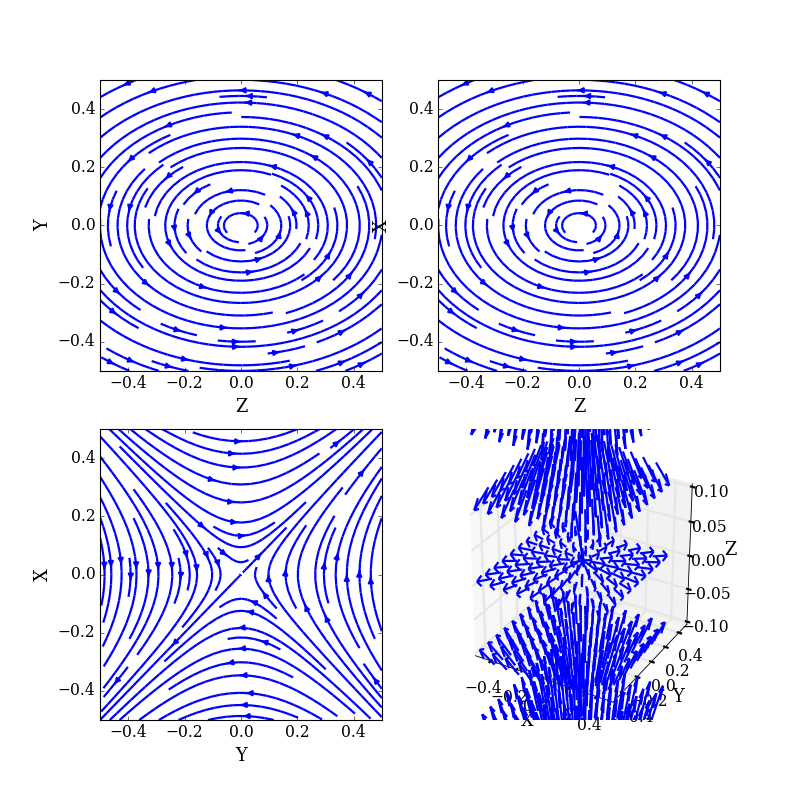

In [8]:
# construct a test case as shown above
num = 100; stride = num/10
x = np.linspace(-0.5,0.5,num)
print x
y = x; z=x
#xv,yv,zv =np.meshgrid(x,y,z,indexing='ij')

xv,yv,zv = np.meshgrid(x,y,z,indexing='xy')  # (ny,nx,nz)
xv = np.transpose(xv,(2,0,1))
yv = np.transpose(yv,(2,0,1))
zv = np.transpose(zv,(2,0,1))
#zv,yv,xv =np.mgrid[-0.5:0.5:101j,-0.5:0.5:101j,-0.5:0.5:101j]
p = 1.0
btx = xv;  bty = p*yv; btz = -(p+1)*zv

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib notebook
import numpy as np
import numpy.ma as ma
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(2, 2)
matplotlib.rcParams['figure.figsize'] = (10, 10.0)
fig = plt.figure()


ax2 = fig.add_subplot(gs[0])
ax2.streamplot(z,y,np.average(btz[:,:,num/2:num/2+1],axis=2),np.average(bty[:,:,num/2:num/2+1],axis=2))
ax2.set_xlabel('Z')
ax2.set_xlim(-0.5, 0.5)
ax2.set_ylabel('Y')
ax2.set_ylim(-0.5, 0.5)

ax2 = fig.add_subplot(gs[1])
ax2.streamplot(z,x,np.average(btz[:,num/2:num/2+1,:],axis=1),np.average(btx[:,num/2:num/2+1,:],axis=1))
ax2.set_xlabel('Z')
ax2.set_xlim(-0.5, 0.5)
ax2.set_ylabel('X')
ax2.set_ylim(-0.5, 0.5)

ax2 = fig.add_subplot(gs[2])
ax2.streamplot(y,x,bty[num/2,:,:],btx[num/2,:,:])
ax2.set_xlabel('Y')
ax2.set_xlim(-0.5, 0.5)
ax2.set_ylabel('X')
ax2.set_ylim(-0.5, 0.5)


skip = np.zeros([num,num,num])
skip = ma.make_mask(skip,shrink=False)
skip[0:num-1:stride,0:num-1:stride,0:num-1:stride] = True


#ax = fig.gca(projection='3d')
ax = fig.add_subplot(gs[3], projection='3d')
ax.quiver(xv[skip],yv[skip],zv[skip],btx[skip], bty[skip], btz[skip],length=0.1) #, rstride=8, cstride=8, alpha=0.3)
#cset = ax.c(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
#cset = ax.contour(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
#cset = ax.contour(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

ax.set_xlabel('X')
ax.set_xlim(-0.5, 0.5)
ax.set_ylabel('Y')
ax.set_ylim(-0.5, 0.5)
ax.set_zlabel('Z')
ax.set_zlim(-0.1, 0.1)

plt.show()




## 3.4.1 First try single null points at origin $^{(a)}$
* $\mathbf{B} = (x,py,-(p+1)z)$ with $p=1$
<img src='download/example_null.png' width=600>

## 3.4.2 Try more general form $^{(b,c)}$
* $\mathbf{B} = (x+(b-j_{\parallel})y/2, (b+j_{\parallel})x+ay, j_{\bot}y-(a+1)z)$ with $a=1$, $b=0$,$j_{\parallel}=0.34$ and $j_{\bot}=0.05$

## 3.4.3 Try add two null points separated in space?
<img src='download/example_null2.png' width=600>

* two null points at (0.59,0.49,0.44) and (0.23,0.11,3.23)



In [56]:
# construct a test case as shown above
#  use the Cartesian indexing


icase = 2
######################################
# (1) single null at origin
if (icase == 0): 
  num = 100
  x = np.linspace(-1.0,1.0,num)
  y = x; z=x
  print x

  xv,yv,zv = np.meshgrid(x,y,z,indexing='xy')  # (ny,nx,nz)
  xv = np.transpose(xv,(2,0,1))
  yv = np.transpose(yv,(2,0,1))
  zv = np.transpose(zv,(2,0,1))
  p = 1.0
  btx = xv;  bty = p*yv; btz = -(p+1)*zv
######################################
# (2) general null point not at origin
if (icase == 1):
  num = 100
  x = np.linspace(-0.5,0.5,num)
  y = x; z=x
  print x
  xv,yv,zv = np.meshgrid(x,y,z,indexing='xy')  # (ny,nx,nz)
  xv = np.transpose(xv,(2,0,1))
  yv = np.transpose(yv,(2,0,1))
  zv = np.transpose(zv,(2,0,1))
  a = 1.0; b = 0.0; jpar = 0.34; jper = 0.05
  s1,s2,s3 = 0.102,0.102,-0.03
  tx = xv+s1;  ty = yv+s2; tz = zv+s3
  btx = tx+(b-jpar)*ty/2.0; bty = (b+jpar)*tx+a*ty; btz = jper*ty-(a+1)*tz
######################################
# (3) double nulls spatially separated
if (icase == 2):
  num = 201
  x = np.linspace(-5.02,5.02,num)
  y = x; z=x
  #print x
  xv,yv,zv = np.meshgrid(x,y,z,indexing='xy')  # (ny,nx,nz)
  xv = np.transpose(xv,(2,0,1))
  yv = np.transpose(yv,(2,0,1))
  zv = np.transpose(zv,(2,0,1))
  btx = -1.8 +(-2.57*xv+6.92*yv+0.44*zv)+( 0.02*yv*zv+0.46*xv*zv-1.40*xv*yv)
  bty = 0.44 +(-3.05*xv+2.09*yv+0.20*zv)+(-0.46*yv*zv-0.34*xv*zv+1.46*xv*yv)
  btz = -0.67+(-2.30*xv+8.69*yv+0.48*zv)+( 1.40*yv*zv-1.46*xv*zv-8.29*xv*yv)
 



# a null pt finding script includes the following parts:
# (1) reduction toward cand list (2) identify real null pts from reduced cand. list

import time
import multiprocessing as mp
from itertools import product


tstart = time.time()  
nx = btx.shape[2]
ny = btx.shape[1]
nz = btx.shape[0]  
#contruct list of argument for parallelization
klist,jlist,ilist = zip(*product(range(nz-1),range(ny-1),range(nx-1)))
#print klist[256*64/4:256*64/4+10]


def positive_negative(inputlist):
  if ((all(item>0 for item in list(inputlist))) or (all(item<0 for item in list(inputlist)))):
    return True  # elements with same sign (+ or -)
  else:
    return False # elements with diff sign or all zeros;
 

def f(location):
  #candidate_pl = []
  k = location[0];j=location[1];i=location[2]
  corner=btx[k:k+2,j:j+2,i:i+2]
  is_bx = positive_negative(np.ravel(corner))
  corner=bty[k:k+2,j:j+2,i:i+2]
  is_by = positive_negative(np.ravel(corner))
  corner=btz[k:k+2,j:j+2,i:i+2]
  is_bz = positive_negative(np.ravel(corner))
  if ((is_bx or is_by or is_bz) == False):
    #candidate_pl.append((k,j,i)) 
    #print '[k,j,i]=',k,j,i
    #print 'length of candiate=',len(candidate_pl)
    return (k,j,i) #candidate_pl
  else:
    return None

result_list=[]
candidate_list=[]
#create a pool and map the target function with multi-arguments
p = mp.Pool(processes=8)
result_list = p.map(f,zip(klist,jlist,ilist))
candidate_list = [item for item in result_list if item is not None]

tend = time.time()


print len(candidate_list)
print
print candidate_list[:5]
print
print 'time cost = ',tend-tstart,' second'
p.close

95

[(100, 110, 112), (101, 110, 112), (102, 110, 112), (103, 109, 111), (103, 110, 112)]

time cost =  77.9246320724  second


<bound method Pool.close of <multiprocessing.pool.Pool object at 0x2b21706c1450>>

In [48]:
for item in candidate_list:
    a,b,c = item[2],item[1],item[0]
    print x[a],y[b],z[c]

-0.106060606061 -0.106060606061 0.0252525252525


In [58]:
bx = btx;by=bty;bz=btz

# function which takes the cell location and solve for intersection points on six surfaces
def bilinear(x,y,f00,f01,f10,f11):
   a = f00; b = f10-f00; c = f01-f00; d = f00+f11-f10-f01
   fxy = a + b*x + c*y + d*x*y
   return fxy

# test if a list has equal number of positive
# and negative values; zeros belong to both.
def issym(b3):
  npos = 0; nneg = 0
  for item in b3:
    if (item >= 0): 
      npos +=1
    if (item <= 0):
      nneg +=1
  if (npos==nneg):
    return True
  else:
    return False

###############################################
# intersection curves Bx=By=0
###############################################
def intersect_bxby(location):
  npts = 0 # # of end points
  b3 = [] # third component values
  sk = location[0];sj=location[1];si=location[2]
  f = bx; g = by; h = bz
    
  for nface in range(6):
    if (nface == 0):  # x = 0 face (y,z) 
      f00,f01,f10,f11 = f[sk,sj,si],f[sk+1,sj,si],f[sk,sj+1,si],f[sk+1,sj+1,si]
      g00,g01,g10,g11 = g[sk,sj,si],g[sk+1,sj,si],g[sk,sj+1,si],g[sk+1,sj+1,si]
      h00,h01,h10,h11 = h[sk,sj,si],h[sk+1,sj,si],h[sk,sj+1,si],h[sk+1,sj+1,si]
    if (nface == 1): # x=1 face 
      f00,f01,f10,f11 = f[sk,sj,si+1],f[sk+1,sj,si+1],f[sk,sj+1,si+1],f[sk+1,sj+1,si+1]
      g00,g01,g10,g11 = g[sk,sj,si+1],g[sk+1,sj,si+1],g[sk,sj+1,si+1],g[sk+1,sj+1,si+1]
      h00,h01,h10,h11 = h[sk,sj,si+1],h[sk+1,sj,si+1],h[sk,sj+1,si+1],h[sk+1,sj+1,si+1]
    if (nface == 2):  # y = 0 face (x,z) 
      f00,f01,f10,f11 = f[sk,sj,si],f[sk+1,sj,si],f[sk,sj,si+1],f[sk+1,sj,si+1]
      g00,g01,g10,g11 = g[sk,sj,si],g[sk+1,sj,si],g[sk,sj,si+1],g[sk+1,sj,si+1]
      h00,h01,h10,h11 = h[sk,sj,si],h[sk+1,sj,si],h[sk,sj,si+1],h[sk+1,sj,si+1]
    if (nface == 3): # y =1 face
      f00,f01,f10,f11 = f[sk,sj+1,si],f[sk+1,sj+1,si],f[sk,sj+1,si+1],f[sk+1,sj+1,si+1]
      g00,g01,g10,g11 = g[sk,sj+1,si],g[sk+1,sj+1,si],g[sk,sj+1,si+1],g[sk+1,sj+1,si+1]
      h00,h01,h10,h11 = h[sk,sj+1,si],h[sk+1,sj+1,si],h[sk,sj+1,si+1],h[sk+1,sj+1,si+1]
    if (nface == 4): # z = 0 face (x,y)
      f00,f01,f10,f11 = f[sk,sj,si],f[sk,sj+1,si],f[sk,sj,si+1],f[sk,sj+1,si+1]
      g00,g01,g10,g11 = g[sk,sj,si],g[sk,sj+1,si],g[sk,sj,si+1],g[sk,sj+1,si+1]
      h00,h01,h10,h11 = h[sk,sj,si],h[sk,sj+1,si],h[sk,sj,si+1],h[sk,sj+1,si+1]
    if (nface == 5): # z=1 face
      f00,f01,f10,f11 = f[sk+1,sj,si],f[sk+1,sj+1,si],f[sk+1,sj,si+1],f[sk+1,sj+1,si+1]
      g00,g01,g10,g11 = g[sk+1,sj,si],g[sk+1,sj+1,si],g[sk+1,sj,si+1],g[sk+1,sj+1,si+1] 
      h00,h01,h10,h11 = h[sk+1,sj,si],h[sk+1,sj+1,si],h[sk+1,sj,si+1],h[sk+1,sj+1,si+1]
        
    a1,b1,c1,d1 = f00,f10-f00,f01-f00,f00+f11-f10-f01
    a2,b2,c2,d2 = g00,g10-g00,g01-g00,g00+g11-g10-g01
    coeff = [(b1*d2-b2*d1), (a1*d2-a2*d1+b1*c2-b2*c1), (a1*c2-a2*c1)]
    sol1 = np.roots(coeff)
    sol2 = -(a2+b2*sol1)/(c2+d2*sol1)
    #  determine if intersection points
    for s,t in zip(sol1,sol2):
       if ((not isinstance(s,complex)) and (not isinstance(t,complex))): 
         if (s>=0 and s<=1 and t>=0 and t<=1):
           npts += 1
           # if yes, calculate the third components on those points
           b3.append(bilinear(s,t,h00,h01,h10,h11))

  #  determine if null pt: (1) intersection points in pair (2) third component flip signs
  #  if yes then return True; else return False
  if (npts>0 and npts%2==0): 
    return issym(b3) 
  else:
    return False

###############################################
# intersection curves By=Bz=0
###############################################
def intersect_bybz(location):
  npts = 0 # # of end points
  b3 = [] # third component values
  sk = location[0];sj=location[1];si=location[2]
  f = by; g = bz; h = bx
    
  for nface in range(6):
    if (nface == 0):  # x = 0 face (y,z) 
      f00,f01,f10,f11 = f[sk,sj,si],f[sk+1,sj,si],f[sk,sj+1,si],f[sk+1,sj+1,si]
      g00,g01,g10,g11 = g[sk,sj,si],g[sk+1,sj,si],g[sk,sj+1,si],g[sk+1,sj+1,si]
      h00,h01,h10,h11 = h[sk,sj,si],h[sk+1,sj,si],h[sk,sj+1,si],h[sk+1,sj+1,si]
    if (nface == 1): # x=1 face 
      f00,f01,f10,f11 = f[sk,sj,si+1],f[sk+1,sj,si+1],f[sk,sj+1,si+1],f[sk+1,sj+1,si+1]
      g00,g01,g10,g11 = g[sk,sj,si+1],g[sk+1,sj,si+1],g[sk,sj+1,si+1],g[sk+1,sj+1,si+1]
      h00,h01,h10,h11 = h[sk,sj,si+1],h[sk+1,sj,si+1],h[sk,sj+1,si+1],h[sk+1,sj+1,si+1]
    if (nface == 2):  # y = 0 face (x,z) 
      f00,f01,f10,f11 = f[sk,sj,si],f[sk+1,sj,si],f[sk,sj,si+1],f[sk+1,sj,si+1]
      g00,g01,g10,g11 = g[sk,sj,si],g[sk+1,sj,si],g[sk,sj,si+1],g[sk+1,sj,si+1]
      h00,h01,h10,h11 = h[sk,sj,si],h[sk+1,sj,si],h[sk,sj,si+1],h[sk+1,sj,si+1]
    if (nface == 3): # y =1 face
      f00,f01,f10,f11 = f[sk,sj+1,si],f[sk+1,sj+1,si],f[sk,sj+1,si+1],f[sk+1,sj+1,si+1]
      g00,g01,g10,g11 = g[sk,sj+1,si],g[sk+1,sj+1,si],g[sk,sj+1,si+1],g[sk+1,sj+1,si+1]
      h00,h01,h10,h11 = h[sk,sj+1,si],h[sk+1,sj+1,si],h[sk,sj+1,si+1],h[sk+1,sj+1,si+1]
    if (nface == 4): # z = 0 face (x,y)
      f00,f01,f10,f11 = f[sk,sj,si],f[sk,sj+1,si],f[sk,sj,si+1],f[sk,sj+1,si+1]
      g00,g01,g10,g11 = g[sk,sj,si],g[sk,sj+1,si],g[sk,sj,si+1],g[sk,sj+1,si+1]
      h00,h01,h10,h11 = h[sk,sj,si],h[sk,sj+1,si],h[sk,sj,si+1],h[sk,sj+1,si+1]
    if (nface == 5): # z=1 face
      f00,f01,f10,f11 = f[sk+1,sj,si],f[sk+1,sj+1,si],f[sk+1,sj,si+1],f[sk+1,sj+1,si+1]
      g00,g01,g10,g11 = g[sk+1,sj,si],g[sk+1,sj+1,si],g[sk+1,sj,si+1],g[sk+1,sj+1,si+1] 
      h00,h01,h10,h11 = h[sk+1,sj,si],h[sk+1,sj+1,si],h[sk+1,sj,si+1],h[sk+1,sj+1,si+1]
        
    a1,b1,c1,d1 = f00,f10-f00,f01-f00,f00+f11-f10-f01
    a2,b2,c2,d2 = g00,g10-g00,g01-g00,g00+g11-g10-g01
    coeff = [(b1*d2-b2*d1), (a1*d2-a2*d1+b1*c2-b2*c1), (a1*c2-a2*c1)]
    sol1 = np.roots(coeff)
    sol2 = -(a2+b2*sol1)/(c2+d2*sol1)
    #  determine if intersection points
    for s,t in zip(sol1,sol2):
       if ((not isinstance(s,complex)) and (not isinstance(t,complex))): 
         if (s>=0 and s<=1 and t>=0 and t<=1):
           npts += 1
           # if yes, calculate the third components on those points
           b3.append(bilinear(s,t,h00,h01,h10,h11))

  #  determine if null pt: (1) intersection points in pair (2) third component flip signs
  #  if yes then return True; else return False
  if (npts>0 and npts%2==0): 
    return issym(b3) 
  else:
    return False

###############################################
# intersection curves Bx=Bz=0
###############################################
def intersect_bxbz(location):
  npts = 0 # # of end points
  b3 = [] # third component values
  sk = location[0];sj=location[1];si=location[2]
  f = bx; g = bz; h = by
    
  for nface in range(6):
    if (nface == 0):  # x = 0 face (y,z) 
      f00,f01,f10,f11 = f[sk,sj,si],f[sk+1,sj,si],f[sk,sj+1,si],f[sk+1,sj+1,si]
      g00,g01,g10,g11 = g[sk,sj,si],g[sk+1,sj,si],g[sk,sj+1,si],g[sk+1,sj+1,si]
      h00,h01,h10,h11 = h[sk,sj,si],h[sk+1,sj,si],h[sk,sj+1,si],h[sk+1,sj+1,si]
    if (nface == 1): # x=1 face 
      f00,f01,f10,f11 = f[sk,sj,si+1],f[sk+1,sj,si+1],f[sk,sj+1,si+1],f[sk+1,sj+1,si+1]
      g00,g01,g10,g11 = g[sk,sj,si+1],g[sk+1,sj,si+1],g[sk,sj+1,si+1],g[sk+1,sj+1,si+1]
      h00,h01,h10,h11 = h[sk,sj,si+1],h[sk+1,sj,si+1],h[sk,sj+1,si+1],h[sk+1,sj+1,si+1]
    if (nface == 2):  # y = 0 face (x,z) 
      f00,f01,f10,f11 = f[sk,sj,si],f[sk+1,sj,si],f[sk,sj,si+1],f[sk+1,sj,si+1]
      g00,g01,g10,g11 = g[sk,sj,si],g[sk+1,sj,si],g[sk,sj,si+1],g[sk+1,sj,si+1]
      h00,h01,h10,h11 = h[sk,sj,si],h[sk+1,sj,si],h[sk,sj,si+1],h[sk+1,sj,si+1]
    if (nface == 3): # y =1 face
      f00,f01,f10,f11 = f[sk,sj+1,si],f[sk+1,sj+1,si],f[sk,sj+1,si+1],f[sk+1,sj+1,si+1]
      g00,g01,g10,g11 = g[sk,sj+1,si],g[sk+1,sj+1,si],g[sk,sj+1,si+1],g[sk+1,sj+1,si+1]
      h00,h01,h10,h11 = h[sk,sj+1,si],h[sk+1,sj+1,si],h[sk,sj+1,si+1],h[sk+1,sj+1,si+1]
    if (nface == 4): # z = 0 face (x,y)
      f00,f01,f10,f11 = f[sk,sj,si],f[sk,sj+1,si],f[sk,sj,si+1],f[sk,sj+1,si+1]
      g00,g01,g10,g11 = g[sk,sj,si],g[sk,sj+1,si],g[sk,sj,si+1],g[sk,sj+1,si+1]
      h00,h01,h10,h11 = h[sk,sj,si],h[sk,sj+1,si],h[sk,sj,si+1],h[sk,sj+1,si+1]
    if (nface == 5): # z=1 face
      f00,f01,f10,f11 = f[sk+1,sj,si],f[sk+1,sj+1,si],f[sk+1,sj,si+1],f[sk+1,sj+1,si+1]
      g00,g01,g10,g11 = g[sk+1,sj,si],g[sk+1,sj+1,si],g[sk+1,sj,si+1],g[sk+1,sj+1,si+1] 
      h00,h01,h10,h11 = h[sk+1,sj,si],h[sk+1,sj+1,si],h[sk+1,sj,si+1],h[sk+1,sj+1,si+1]
        
    a1,b1,c1,d1 = f00,f10-f00,f01-f00,f00+f11-f10-f01
    a2,b2,c2,d2 = g00,g10-g00,g01-g00,g00+g11-g10-g01
    coeff = [(b1*d2-b2*d1), (a1*d2-a2*d1+b1*c2-b2*c1), (a1*c2-a2*c1)]
    sol1 = np.roots(coeff)
    sol2 = -(a2+b2*sol1)/(c2+d2*sol1)
    #  determine if intersection points
    for s,t in zip(sol1,sol2):
       if ((not isinstance(s,complex)) and (not isinstance(t,complex))): 
         if (s>=0 and s<=1 and t>=0 and t<=1):
           npts += 1
           # if yes, calculate the third components on those points
           b3.append(bilinear(s,t,h00,h01,h10,h11))

  #  determine if null pt: (1) intersection points in pair (2) third component flip signs
  #  if yes then return True; else return False
  if (npts>0 and npts%2==0): 
    return issym(b3) 
  else:
    return False

import time
import multiprocessing as mp
from itertools import product


tstart = time.time()  

#create a pool and map the target function with multi-arguments
p = mp.Pool(processes=8)

# first pass: finding intersection of Bx=By=0
mask_list = p.map(intersect_bxby, candidate_list)
cell = [candidate_list[i] for i in range(len(candidate_list)) if mask_list[i]]
               

tend = time.time()
print 'time cost for the 1st pass = ',tend-tstart,' seconds'
print type(cell)
print cell
print len(cell)


tstart = time.time() 
# second pass: finding intersection of By=Bz=0
for cell_one in cell:
  if (not intersect_bybz(cell_one)):
    cell.remove(cell_one)
tend = time.time()
print 'time cost for the 2nd pass = ',tend-tstart,' seconds'
print type(cell)
print cell
print len(cell)


# third pass: finding intersection of Bx=Bz=0
for cell_one in cell:
  if (not intersect_bxbz(cell_one)):
    cell.remove(cell_one) 
tend = time.time()
print 'time cost for the 3rd pass = ',tend-tstart,' seconds'
print type(cell)
print cell[:5]
print len(cell)
print
print 'find ',len(cell),' magnetic null points at cell ', cell
print 'the first several of null points at '
for item in cell:
    a,b,c = item[2],item[1],item[0]
    print x[a],y[b],z[c]

p.close

time cost for the 1st pass =  0.803005933762  seconds
<type 'list'>
[(108, 109, 111), (164, 102, 105)]
2
time cost for the 2nd pass =  0.00200915336609  seconds
<type 'list'>
[(108, 109, 111), (164, 102, 105)]
2
time cost for the 3rd pass =  0.00412511825562  seconds
<type 'list'>
[(108, 109, 111), (164, 102, 105)]
2

find  2  magnetic null points at cell  [(108, 109, 111), (164, 102, 105)]
the first several of null points at 
0.5522 0.4518 0.4016
0.251 0.1004 3.2128


<bound method Pool.close of <multiprocessing.pool.Pool object at 0x2b21409e31d0>>

In [54]:
a = np.array([[1,2],[3,4]]); b=np.array([[4,1],[2,2]])
print a
print
print b
print
print a*b

[[1 2]
 [3 4]]

[[4 1]
 [2 2]]

[[4 2]
 [6 8]]


**Chapter 14
Three Dimensional Magnetic Reconnection at Null Points
and Separators
Clare E. Parnell, Andrew L. Haynes, and Rhona C. Maclean**
<img src="excerpt.png" width=400>

In [ ]:
btx = -1.8 +(-2.57*xv+6.92*yv+0.44*zv)+( 0.02*yv*zv+0.46*xv*zv-1.40*xv*yv)
bty = 0.44 +(-3.05*xv+2.09*yv+0.20*zv)+(-0.46*yv*zv-0.34*xv*zv+1.46*xv*yv)
btz = -0.67+(-2.30*xv+8.69*yv+0.48*zv)+( 1.40*yv*zv-1.46*xv*zv-8.29*xv*yv)